In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tools
import fitutils as ft
import schottky_analysis
import near0_linear_analysis
import near0_nonlinear_analysis

In [2]:

# Data import

from data import temperature
from data import sample_HC
from data import err_sample_HC
from data import err_temperature

squared_temperature = temperature**2  # K**2
C_div_T = sample_HC/temperature  # mJ/K**2.mol
err_C_divT = sample_HC*((err_temperature/temperature) **
                        2 + (err_sample_HC/sample_HC)**2) # error on C/T
err_squared_temperature = (temperature)*2*err_temperature # error on T²


In [3]:
# Constants

k = 1.380649e-23 # Boltzmann, J/K
delta = 2.9461005*k*2.4 
r = 8.31446261815324  # J/mol.K

### I. Plotting data

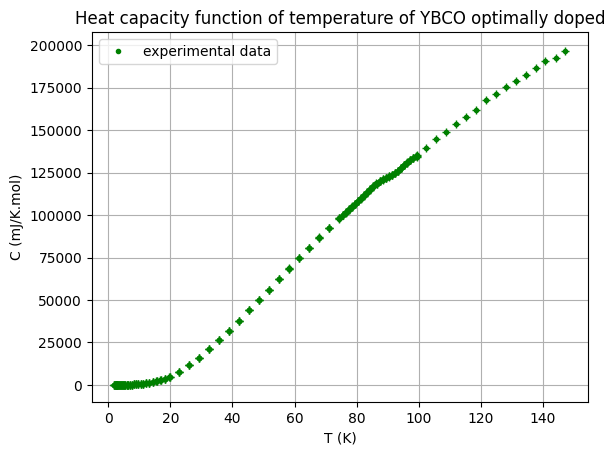

In [4]:
# Plot of HC(T)

plt.figure()
plt.plot(temperature, sample_HC, ".g", label="experimental data")
plt.errorbar(temperature, sample_HC, err_sample_HC, err_temperature, "+g")
plt.grid(True)
plt.xlabel("T (K)")
plt.ylabel("C (mJ/K.mol)")
plt.title("Heat capacity function of temperature of YBCO optimally doped")
plt.legend()
plt.show()


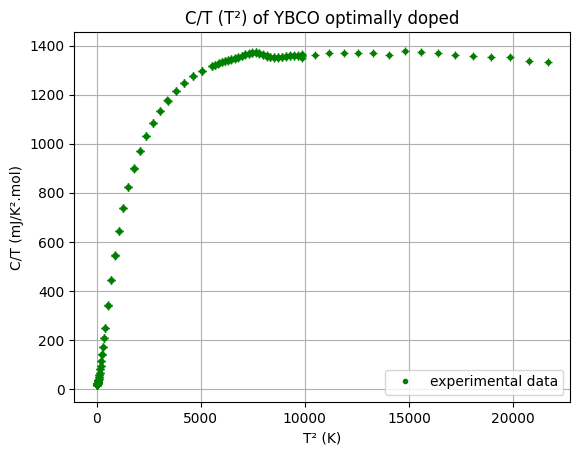

In [5]:
# Plot of HC/T (T**2)

plt.figure()
plt.plot(squared_temperature, C_div_T, ".g", label="experimental data")
plt.errorbar(squared_temperature, C_div_T, err_C_divT,
             err_squared_temperature, "+g")
plt.grid(True)
plt.xlabel("T² (K)")
plt.ylabel("C/T (mJ/K².mol)")
plt.title("C/T (T²) of YBCO optimally doped")
plt.legend()
plt.show()

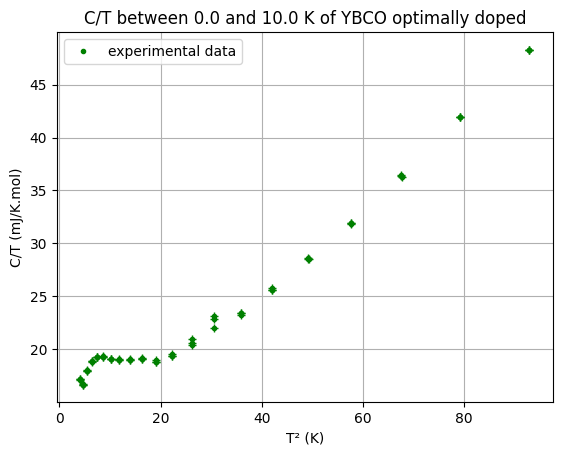

In [6]:
# Plot of HC/T (T²) near 0

# Choose of bounds

a = int(input("Input the lower bound of T² : "))
b = int(input("Input the higher bound of T² : "))
x, y = tools.tab_interval(squared_temperature, C_div_T, a, b)
x_err, y_err = err_squared_temperature[0:len(x)], err_C_divT[0:len(y)]
a_sqrt = str(np.sqrt(a))
b_sqrt = str(np.sqrt(b))
title = "C/T between " + a_sqrt + " and "  + b_sqrt + " K of YBCO optimally doped"

# Plotting 

plt.figure()
plt.plot(x, y, ".g", label="experimental data")
plt.errorbar(x, y, y_err, x_err, "+g")
plt.grid(True)
plt.xlabel("T² (K)")
plt.ylabel("C/T (mJ/K.mol)")
plt.title(title)
plt.legend()
plt.show()

### II. Schottky anomaly study

The Schottky anomaly is a term appearing in the expression for the specific heat of certain solids at low temperature; it arises from the presence of a two-level energy system and is modeled accordingly. Its expression is therefore:
$$C_{s} = n R (\frac{E}{k_B T})^2 \frac{\exp(\frac{E}{k_B T})}{(\exp(\frac{E}{k_B T}) + 1)²}$$

The parameters to be defined are $n$ (the fraction of atoms participating in the two-level system) and $E$, the energy gap between the two levels.

To determine $E$, one can establish a relation between the abscissa of the maximum of the curve, $T_{max}$​, and $E$, such that $E = \alpha T_{max} {B}$. To find  $\alpha$, one computes the derivative of the Schottky contribution, $$\frac{dC_s}{dT} = $$

and sets it to zero at the condition $(2T +) .. = 0$. This equation admits no closed-form solution and must be solved numerically; here it was treated with the Newton–Raphson algorithm, yielding $\alpha = 2.512$.

Next, the maximum of the curve and the corresponding temperature $T_{max}$  are obtained from experimental low-temperature data (<4 K). One finds $T_{max} = 2.9461005 K$ and  $C_s(T_{max}) = 19.3365 mJ.K^{-2}.mol{-1}$

Concerning $n$, the fraction of sites involved in the two-level system, its order of magnitude can be estimated for each experimental point once $E$ is known. Although these values may be noisy due to contributions from other terms, the average of the $n$ values calculated over the range $1K$ to $4 K$, where the Schottky anomaly dominates, can provide a reliable approximation.

In [7]:
# Find the relation between the extremum of Schottky anomaly and T_max

alpha = schottky_analysis.alpha()

T_max, maximum = schottky_analysis.max_schottky(temperature, C_div_T, 0, 4.5)

# Determination of E parameter

E_experimental = k*alpha*T_max

# Determination of n parameter

n_experimental = schottky_analysis.n_experimental(temperature[0:25], C_div_T[0:25], E_experimental) #approximation de n entre 0 et 4 K

print("alpha, T_max, maximum, E_experimental, n_experimental : ", alpha, T_max, maximum, E_experimental, n_experimental)


alpha, T_max, maximum, E_experimental, n_experimental :  2.399357557296753 2.9461005 19.33658610763618 9.759460546714425e-23 0.002086138736124589


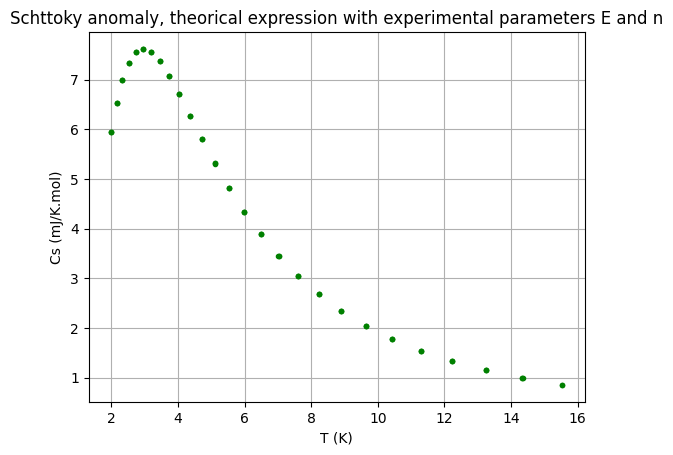

In [8]:
# Plotting Schottky

plt.figure()
plt.plot(temperature[0:80], schottky_analysis.schottky(temperature[0:80], E_experimental, n_experimental), ".g")
plt.grid(True)
plt.xlabel("T (K)")
plt.ylabel("Cs (mJ/K.mol)")
plt.title("Schttoky anomaly, theorical expression with experimental parameters E and n")
plt.show()


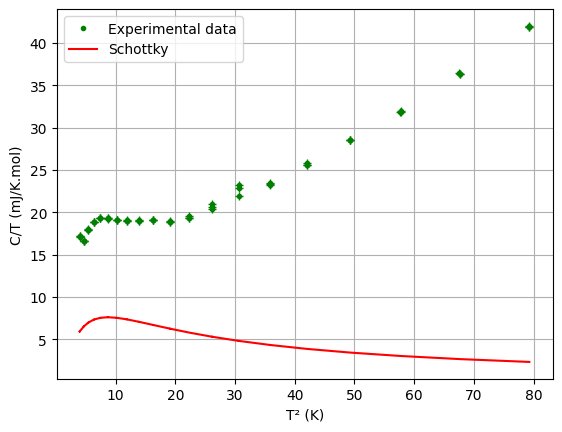

In [9]:
# Plot of HC/T and Cs (T²) near 0

# Choose of bounds

a = int(input("Input the lower bound of T² : "))
b = int(input("Input the higher bound of T² : "))
x, y = tools.tab_interval(squared_temperature, C_div_T, a, b)
x_err, y_err = err_squared_temperature[0:len(x)], err_C_divT[0:len(y)]

# Plotting 

plt.figure()
plt.plot(x, y, ".g", label="Experimental data")
plt.plot(x, schottky_analysis.schottky(temperature[0:len(x)], E_experimental, n=n_experimental), "r-", label="Schottky")
plt.errorbar(x, y, y_err, x_err, "+g")
plt.grid(True)
plt.xlabel("T² (K)")
plt.ylabel("C/T (mJ/K.mol)")
plt.legend()
plt.show()

### III. Linear regression 

The theoretical expression for $\frac{C}{T}$ is given by: $\gamma + \beta T² + C_{schottky} $. By subtracting the Schottky contribution and plotting the remaining data as a function of $T²$, one obtains a linear relation: $\frac{C-C_{s}}{T} = \gamma + \beta x$, ($x = T²$)

A linear fit of $\frac{C-C_{s}}{T}$ versus $T²$ then yields the parameters $\gamma$ and $\beta$.


The parameter $\beta$ is related to the Debye temperature $T_D$ of the compound by $T_D = (\frac{12 R \pi ^4}{5 \beta})^{\frac{1}{3}}$

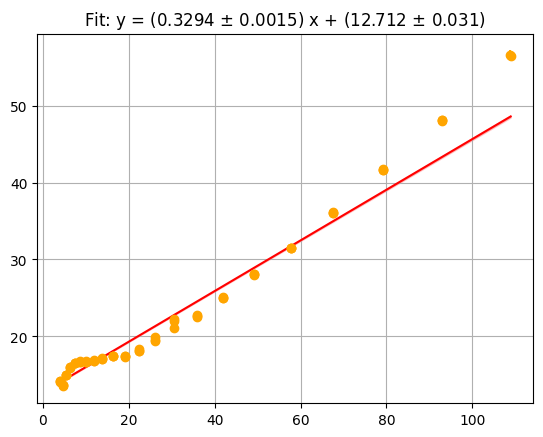

[3.29433247e-01 1.27120951e+01 1.45540746e-03 3.05318355e-02]
180.74020881582183 0.012718094106654733 0.27873103057365767 3.053548110887583e-05


In [10]:
# Linear fit of experimental data, with the 65st values (0-15 K)

print(near0_linear_analysis.plot_linear_fit(65, E=E_experimental, n=n_experimental))

# Debye temperature

TDebye, gamma, u_TDebye, u_gamma = near0_linear_analysis.debye_temperature(65, E=E_experimental, n=n_experimental)

print(TDebye, gamma, u_TDebye, u_gamma )

One obtains a Debye temperature  $T_D = 180 \pm 0.27\, K$ and an intercept $\gamma = 13.3 \pm 0.0289 mJ.K^{-2}.mol^{-1}$.

The linear fit is not visually very satisfactory, as a Schottky contribution appears to remain. We therefore propose to repeat the same procedure but by manually choosing a larger value of nn. For $n = 10^{-2}$, we obtain :

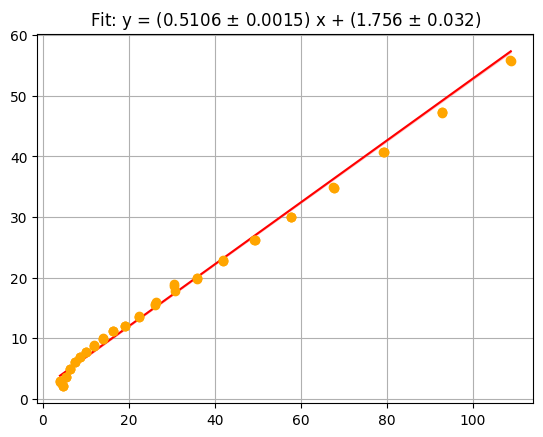

[5.10572696e-01 1.75569699e+00 1.49428657e-03 3.15842197e-02]
TDebye, gamma, u_TDebye, u_gamma :  156.16044480855712 0.0017585950367053715 0.15517806231432668 3.0270873282586486e-05


In [19]:
# Linear fit of experimental data, with the 65st values (0-15 K) and n=1e-2

print(near0_linear_analysis.plot_linear_fit(65, E=E_experimental, n=1e-2))

# Debye temperature

TDebye, gamma, u_TDebye, u_gamma = near0_linear_analysis.debye_temperature(65, E=E_experimental, n=1e-2)

print("TDebye, gamma, u_TDebye, u_gamma : ", TDebye, gamma, u_TDebye, u_gamma)

We now obtain a Debye temperature  $T_D = 182.56 \pm \, K$ and an intercept $\gamma = 13.3 \pm 0.02917 mJ.K^{-2}.mol^{-1}$, This result is in fact very close to what was previously obtained. We can therefore conclude that the value of $n$ has little influence on the Debye temperature—within a factor of 10.

### IV. Non-linear regression

The data can also be directly fitted using the theoretical expression.

Beta, Gamma, n :  0.42973361391098025 6.643992011420609 0.006470405531165617


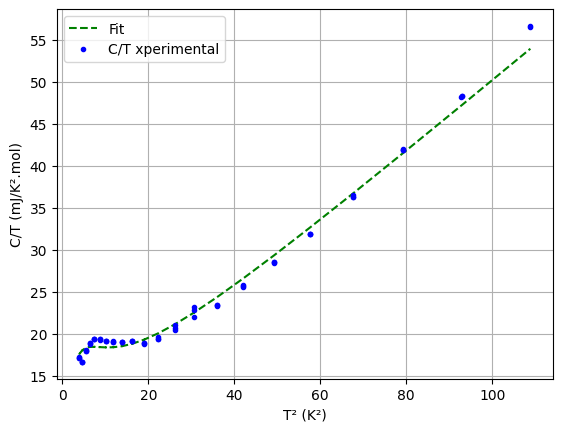

Debye temperature :  165.37957211855118


In [12]:
# Non linear fit of experimental data, with the 65st values (0-15 K) and n=1e-2

beta_curve, gamma_curve, n_curve = near0_nonlinear_analysis.nonlinear_fit(65)

print("Beta, Gamma, n : ", beta_curve, gamma_curve, n_curve)

# Plotting non linear fit

near0_nonlinear_analysis.plot_fit(65,beta_curve, gamma_curve, n_curve)

# Debye temperature

TDebye_curvefit = near0_nonlinear_analysis.debye_temperature(65)

print("Debye temperature : ", TDebye_curvefit)

Here, a Debye temperature of 165 K is obtained. This value is of the same order of magnitude as that found through the linear analysis. The corresponding value of $n$ is $6,4 .10^{-3}$, which is closer to the previously determined value ($2.10^{-3}$) than to the one used in the linear fit